<a href="https://colab.research.google.com/github/mlwright84/magictriangles/blob/main/Simulated_Annealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Magic Triangles by Simulated Annealing 

by Gabriel Hale, Bjorn Vogen, and Matthew Wright

This file contains the Python code to find magic triangles by simulated annealing. This was used to collect the data for Figure 6 in our *Magic Triangles* paper.

## Import modules and define magic triangle functions

Note that an $n$-level triangular arrangement is stored as a list of $n^2$ entries, indexed left-to-right, bottom-to-top as in our paper (see Figure 2 in the paper). However, Python indexes start at 0, while indexes in the paper start at 1.

In [1]:
import copy
import numpy as np
import math
import random as rd
import matplotlib.pyplot as plt
import time
import statistics as stats
import pandas as pd

# function to generate a random n-level triangle 
def generateRandomTriangle(n):                  
    return rd.sample(range(1,n*n+1), n*n)

# function to compute how far a given triangle is from a magic triangle
def findDistFromMagic(tri):
  n = int(math.sqrt(len(tri)))  # number of levels in triangle
  
  # horizontal row sums
  horiz = [0]*n
  for k in range(n):
    #print("computing horizontal sum", k)
    for i in range(2*k*n - k*k, 2*(k+1)*(n-1)-k*k+1):
      #print(" ", i, end=" ")
      horiz[k] += tri[i]
    #print("   sum:", horiz[k])
  
  # positive slope row sums
  pos = [0]*n
  for k in range(n):
    #print("computing pos slope sum", k)
    for j in range(0, n-k-1):
      #print(" ", j*(2*n-j)+2*k, j*(2*n-j)+2*k+1, end=" ")
      pos[k] += tri[j*(2*n-j)+2*k] + tri[j*(2*n-j)+2*k+1]
    #print("", n*n-(k+1)**2+2*k, sep=" ")
    pos[k] += tri[n*n-(k+1)**2+2*k]
    #print("   sum:", pos[k])
  
  # negative slope row sums
  neg = [0]*n
  for k in range(n):
    #print("computing neg slope sum", k)
    for j in range(1, n-k):
      #print(" ", j*(2*n-j)-2*k-2, j*(2*n-j)-2*k-1, end=" ")
      neg[k] += tri[j*(2*n-j)-2*k-2] + tri[j*(2*n-j)-2*k-1]
    #print("", n*n - (k+1)**2, sep=" ")
    neg[k] += tri[n*n - (k+1)**2]
    #print("   sum:", neg[k])

  # compute distance from magic
  mag = n*(n*n+1)
  dist = 0
  for i in range(math.ceil(n/2)):
    h = horiz[i] + horiz[n-1-i]
    p = pos[i] + pos[n-1-i]
    q = neg[i] + neg[n-1-i]
    dist = max(dist, abs(h-mag), abs(p-mag), abs(q-mag))

  return dist

# fast distance function
# computes how far a given triangle is from a magic triangle
# indexes are hard-coded for speed: this function is about 3-4 times faster than findDistFromMagic()
def fastDist(t):

  if len(t) == 9:  # 3-level triangle
    sums = [0]*6
    sums[0] = sum(t[:5]) + t[8]       # horisontal sum: top and bottom rows
    sums[1] = 2*sum(t[5:8])           # horizontal sum
    sums[2] = sum([t[i] for i in [0,1,4,5,6,8]])   # positive-slope sum
    sums[3] = 2*sum([t[i] for i in [2,3,7]])       # positive-slope sum
    sums[4] = sum([t[i] for i in [0,3,4,6,7,8]])   # negative-slope sum
    sums[5] = 2*sum([t[i] for i in [1,2,5]])       # negative-slope sum

    diff = [abs(30 - s) for s in sums]
    return max(diff)

  if len(t) == 16:  # 4-level triangle
    sums = [0]*6
    sums[0] = sum(t[:7]) + t[15]       # horisontal sum: top and bottom rows
    sums[1] = sum(t[7:15])             # horizontal sum
    sums[2] = sum([t[i] for i in [0,1,7,8,12,13,15,6]])     # positive-slope sum
    sums[3] = sum([t[i] for i in [2,3,4,5,9,10,11,14]])     # positive-slope sum
    sums[4] = sum([t[i] for i in [0,5,6,10,11,13,14,15]])   # negative-slope sum
    sums[5] = sum([t[i] for i in [1,2,3,4,7,8,9,12]])       # negative-slope sum

    diff = [abs(68 - s) for s in sums]
    return max(diff)

  if len(t) == 25:  # 5-level triangle
    sums = [0]*9
    sums[0] = sum(t[:9]) + t[24]       # horisontal sum: top and bottom rows
    sums[1] = sum(t[9:16] + t[21:24])  # horizontal sum
    sums[2] = 2*sum(t[16:21])          # horizontal sum
    sums[3] = t[0]+t[1]+t[9]+t[10]+t[16]+t[17]+t[21]+t[22]+t[24]+t[8]  # positive-slope sum
    sums[4] = t[2]+t[3]+t[11]+t[12]+t[18]+t[19]+t[23]+t[6]+t[7]+t[15]  # positive-slope sum
    sums[5] = 2*(t[4]+t[5]+t[13]+t[14]+t[20])                          # positive-slope sum
    sums[6] = t[0]+t[7]+t[8]+t[14]+t[15]+t[19]+t[20]+t[22]+t[23]+t[24] # negative-slope sum
    sums[7] = t[1]+t[2]+t[9]+t[5]+t[6]+t[12]+t[13]+t[17]+t[18]+t[21]   # negative-slope sum
    sums[8] = 2*(t[3]+t[4]+t[10]+t[11]+t[16])                          # negative-slope sum

    diff = [abs(130 - s) for s in sums]
    return max(diff)

  if len(t) == 36:  # 6-level triangle
    sums = [0]*9
    sums[0] = sum(t[:11]) + t[35]       # horisontal sum: top and bottom rows
    sums[1] = sum(t[11:20] + t[32:35])  # horizontal sum
    sums[2] = sum(t[20:32])             # horizontal sum
    sums[3] = sum([t[i] for i in [0,1,11,12,20,21,27,28,32,33,35,10]])  # positive-slope sum
    sums[4] = sum([t[i] for i in [2,3,13,14,22,23,29,30,34,8,9,19]])  # positive-slope sum
    sums[5] = sum([t[i] for i in [4,5,6,7,15,16,17,18,24,25,26,31]])  # positive-slope sum
    sums[6] = sum([t[i] for i in [0,9,10,18,19,25,26,30,31,33,34,35]])  # negative-slope sum
    sums[7] = sum([t[i] for i in [1,2,11,7,8,16,17,23,24,28,29,32]])  # negative-slope sum
    sums[8] = sum([t[i] for i in [3,4,12,13,20,5,6,14,15,21,22,27]])  # negative-slope sum
    
    diff = [abs(222 - s) for s in sums]
    return max(diff)
  
  if len(t) == 49:  # 7-level triangle
    sums = [0]*12
    sums[0] = sum(t[:13]) + t[48]       # horisontal sum: top and bottom rows
    sums[1] = sum(t[13:24] + t[45:48])  # horizontal sum
    sums[2] = sum(t[24:33] + t[40:45])  # horizontal sum
    sums[3] = 2*sum(t[33:40])           # horizontal sum
    sums[4] = sum([t[i] for i in [0,1,13,14,24,25,33,34,40,41,45,46,48,12]])  # positive-slope sum
    sums[5] = sum([t[i] for i in [2,3,15,16,26,27,35,36,42,43,47,10,11,23]])  # positive-slope sum
    sums[6] = sum([t[i] for i in [4,5,17,18,28,29,37,38,44,8,9,21,22,32]])    # positive-slope sum
    sums[7] = 2*sum([t[i] for i in [6,7,19,20,30,31,39]])                     # positive-slope sum
    sums[8] = sum([t[i] for i in [0,11,12,22,23,31,32,38,39,43,44,46,47,48]])  # negative-slope sum
    sums[9] = sum([t[i] for i in [13,1,2,9,10,20,21,29,30,36,37,41,42,45]])  # negative-slope sum
    sums[10] = sum([t[i] for i in [3,4,14,15,24,7,8,18,19,27,28,34,35,40]])  # negative-slope sum
    sums[11] = 2*sum([t[i] for i in [5,6,16,17,25,26,33]])  # negative-slope sum
    
    diff = [abs(350 - s) for s in sums]
    return max(diff)

  if len(t) == 64:  # 8-level triangle
    sums = [0]*12
    sums[0] = sum(t[:15]) + t[63]       # horisontal sum: top and bottom rows
    sums[1] = sum(t[15:28] + t[60:63])  # horizontal sum
    sums[2] = sum(t[28:39] + t[55:60])  # horizontal sum
    sums[3] = sum(t[39:55])             # horizontal sum
    sums[4] = sum([t[i] for i in [0,1,15,16,28,29,39,40,48,49,55,56,60,61,63,14]])  # positive-slope sum
    sums[5] = sum([t[i] for i in [2,3,17,18,30,31,41,42,50,51,57,58,62,12,13,27]])  # positive-slope sum
    sums[6] = sum([t[i] for i in [4,5,19,20,32,33,43,44,52,53,59,10,11,25,26,38]])  # positive-slope sum
    sums[7] = sum(t[6:10]+t[21:25]+t[34:38]+t[45:48])+t[54]                         # positive-slope sum
    sums[8] = sum([t[i] for i in [0,13,14,26,27,37,38,46,47,53,54,58,59,61,62,63]]) # negative-slope sum
    sums[9] = sum([t[i] for i in [1,2,15,11,12,24,25,35,36,44,45,51,52,56,57,60]])  # negative-slope sum
    sums[10] = sum([t[i] for i in [3,4,16,17,28,9,10,22,23,33,34,42,43,49,50,55]])  # negative-slope sum
    sums[11] = sum(t[5:9]+t[18:22]+t[29:33]+t[39:42])+t[48]                         # negative-slope sum
    
    diff = [abs(520 - s) for s in sums]
    return max(diff)

  print("fastDist IS NOT IMPLEMENTED FOR THIS SIZE TRIANGLE")
  return None

# function to draw a triangle using matplotlib
# also computes and draws the sums in each direction
def drawTriangle(tri):
  n = int(math.sqrt(len(tri)))
  s = math.sqrt(3)

  plt.figure(figsize=(n,n*s/2))

  # draw triangle edges
  for i in range(n):
    plt.plot([i/2,n-i/2],[i*s/2,i*s/2],'b')
    plt.plot([i,(n+i)/2],[0,(n-i)*s/2],'b')
    plt.plot([i+1,(i+1)/2],[0,(i+1)*s/2],'b')

  # print entries in subtriangles
  xind = 1     # horizontal index of the next number to print
  xskip = 0    # number of horizontal positions to skip in the current row
  xwrap = 2*n  # move to the next row when xindex equals this
  row = 0      # row index, 0 indicates bottom row

  for num in tri:
    yadj = 0.2 if xind%2 == 1 else 0.45
    plt.text((xskip + xind)/2, row*s/2 + yadj, num, fontsize=15, horizontalalignment='center')
    xind += 1
    if xind == xwrap:
      xind = 1
      xwrap -= 2
      xskip += 1
      row += 1

  # compute and print sums
  first = 0
  length = 2*n - 1
  rowSums = [0]*n
  posSlopeSums = [0]*n
  negSlopeSums = [0]*n
  for i in range(n):  # loop over rows
    # compute and print horizontal sums
    rowSums[i] = sum(tri[first:first+length])
    plt.plot([n-i/2,n-i/2+0.3],[i*s/2+0.4,i*s/2+0.4],'g-')
    plt.text(n-i/2+0.4 , i*s/2+0.3, rowSums[i], fontsize=15, color='g')  # horizontal sums

    # compute positive-slope sums
    for j in range((length-1)//2):
      posSlopeSums[j] += tri[first+j*2] + tri[first+j*2+1]
    posSlopeSums[(length-1)//2] += tri[first+length-1]

    # compute negative slope sums
    negSlopeSums[i] += tri[first]
    for j in range((length-1)//2):
      negSlopeSums[j+i+1] += tri[first+j*2+1] + tri[first+j*2+2]

    # update indexes
    first += length
    length -= 2

  # print positive and negative slope sums
  for i in range(n):
    plt.plot([i+0.4, i+0.25], [-0.2, -0.46],'m-')
    plt.text(i, -0.9, posSlopeSums[i], fontsize=15, color='m')  # positive slope sums
    plt.plot([0.5*i+.15, 0.5*i], [0.65+i*s/2, 0.91+i*s/2],'r-')
    plt.text(0.5*i-0.4, 1.05+i*s/2, negSlopeSums[i], fontsize=15, color='r')  # negative slope sums

  
  plt.axis("off")

  # return the horizontal, positive slope, and negative slope sums
  horizSums = [rowSums[i] + rowSums[n-1-i] for i in range((n+1)//2)]
  posSums = [posSlopeSums[i] + posSlopeSums[n-1-i] for i in range((n+1)//2)]
  negSums = [negSlopeSums[i] + negSlopeSums[n-1-i] for i in range((n+1)//2)]
  return [horizSums, posSums, negSums]

**Demo:** generate a random triangle, find its distance from magic, and draw it

distance from magic: 92


[[342, 364, 346, 346], [358, 380, 309, 356], [336, 372, 296, 442]]

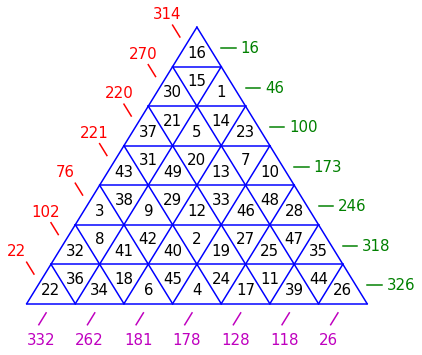

In [ ]:
tri = generateRandomTriangle(7)
print("distance from magic:", findDistFromMagic(tri))
drawTriangle(tri)

## Functions for simulated annealing

These functions allow us to find magic triangles via simulated annealing.

In [2]:
# function that uses simulated annealing to find a n-level magic triangle
# parameters:
#   n        size of triangle (number of levels)
#   distFn   function to use to determine distance from magic
#   decFac   factor by which the "temperature" is decreased with each step of simulated annealing
#   reset    number of steps after which the "temperature" is reset to 1/2
#   maxStep  max number of steps to simulate; will quit after this many steps
# returns: 
#   dist         final distance from magic (0 iff a magic triangle was found)
#   tri          the resulting triangle, as a list of entries
#   stepCounter  number of steps until either a magic triangle was found or maxSteps was reached
#   sig          final value of the "temperature" parameter
def findMagicTriangle(n, distFn, decFac, reset=20000, maxStep = 500000):
  tri = generateRandomTriangle(n)
  dist = distFn(tri)  #findDistFromMagic(state)
  stepCounter  = 0
  sig = 1

  while dist != 0 and stepCounter < maxStep:
    (tri, dist) = doStep(tri, sig, distFn)
    sig = sig*decFac
    stepCounter += 1
    if stepCounter % reset == 0:  # increase the temperature periodically if no magic triangle has been found
      sig = 0.5

  return dist, tri, stepCounter, sig


# function to do one step of simulated annealing
# arguments: triangle t1, temperature parameter sig, and distance function distFn
def doStep(t1, sig, distFn):
    # propose a swap of two randomly-selected entries
    i = rd.randrange(len(t1))
    j = rd.randrange(len(t1))
    while i == j:
        i = rd.randrange(len(t1))
        j = rd.randrange(len(t1))

    # swap the entries on a copy of the triangle
    t2 = copy.copy(t1)
    t2[i] = t1[j]
    t2[j] = t1[i]

    # compute distances from magic
    d1 = distFn(t1)
    d2 = distFn(t2)
    dh = d1-d2

    # decide whether to accep the proposed swap
    if dh >= 0: # then accept proposed swap
        return (t2,d2)
    
    # else: accept proposed swap with probability rho
    rho = math.exp(dh/sig)
    rand = rd.random()
    if rand < rho:
        return (t2,d2) # accept swap
    return (t1,d1)     # reject swap

**Demo:** simulated annealing to find a magic triangle

(0, [4, 12, 6, 1, 18, 22, 21, 17, 10, 25, 15, 7, 14, 5, 9, 23, 24, 2, 20, 8, 11, 3, 16, 13, 19], 13007, 0.024682724731064528)


[[130, 130, 130], [130, 130, 130], [130, 130, 130]]

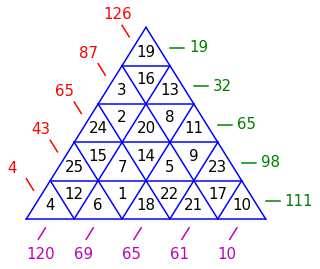

In [ ]:
res = findMagicTriangle(5, fastDist, .999, 10000, 500000)
print(res)
drawTriangle(res[1])

# Collect statistics on finding magic triangles

This code was used to collect data for the paper. The runtime for the following code cell is more than 12 hours.

In [ ]:
# (n, decFac, reset)
paramVals = [(3, 0.9, 10000), (4, 0.94, 10000), (5, 0.997, 10000), (6, 0.994, 30000), (7, 0.998, 40000), (8, 0.999, 80000)]
numTrials = 10000
simAnnDF = pd.DataFrame(columns=["n","successes","avg steps","median steps","max steps"])

for (n,df,reset) in paramVals:
  numSuccess = 0
  stepList = [0]*numTrials
  for i in range(numTrials):
    res = findMagicTriangle(n, fastDist, df, reset, 5000000)
    if res[0] == 0:
      numSuccess += 1
      stepList[i] = res[2]
    if i % 2000 == 1999:
      print("| n =", n, "; completed", (i+1))
  row = pd.Series( {"n": n, "successes": numSuccess, "avg steps": stats.mean(stepList), "median steps": stats.median(stepList), "max steps": max(stepList)})
  simAnnDF = simAnnDF.append(row, ignore_index=True)
  print(row)



| n = 3 ; completed 2000
| n = 3 ; completed 4000
| n = 3 ; completed 6000
| n = 3 ; completed 8000
| n = 3 ; completed 10000
n                   3.0000
successes       10000.0000
avg steps          94.1434
median steps       71.0000
max steps         813.0000
dtype: float64
| n = 4 ; completed 2000
| n = 4 ; completed 4000
| n = 4 ; completed 6000
| n = 4 ; completed 8000
| n = 4 ; completed 10000
n                   4.0000
successes       10000.0000
avg steps         276.8782
median steps      205.0000
max steps        2452.0000
dtype: float64
| n = 5 ; completed 2000
| n = 5 ; completed 4000
| n = 5 ; completed 6000
| n = 5 ; completed 8000
| n = 5 ; completed 10000
n                   5.0000
successes       10000.0000
avg steps        5932.8047
median steps     3179.0000
max steps       92940.0000
dtype: float64
| n = 6 ; completed 2000
| n = 6 ; completed 4000
| n = 6 ; completed 6000
| n = 6 ; completed 8000
| n = 6 ; completed 10000
n                   6.0000
successes       100

In [ ]:
simAnnDF

,n,successes,avg steps,median steps,max steps
0,3.0,10000.0,94.1434,71.0,813.0
1,4.0,10000.0,276.8782,205.0,2452.0
2,5.0,10000.0,5932.8047,3179.0,92940.0
3,6.0,10000.0,7696.4139,5536.0,62520.0
4,7.0,10000.0,45636.9141,33309.0,397088.0
5,8.0,10000.0,246845.9332,174527.5,2575007.0


# Preliminary experiments to choose parameter values

This section contains a sample of the prelimary experiments used to choose the parameter values for the data collection above. This is just a sample of the experiments that we performed; not all past experiments are recorded here.

## 3-level experiments

Summary: decrease factors near 0.9 seem to work best, with a median number of steps about 70

In [4]:
# find avg. number of steps for various decFac values
decFacs = [0.85, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 0.99, 0.994, 0.997]
numTrials = 10000
df3 = pd.DataFrame(columns=["decFac","successes","avg steps","median steps","max steps"])

for d in decFacs:
  numSuccess = 0
  stepList = [0]*numTrials
  for i in range(numTrials):
    res = findMagicTriangle(3, fastDist, d, 10000, 1000000)
    if res[0] == 0:
      numSuccess += 1
      stepList[i] = res[2]
  row = pd.Series( {"decFac": d, "successes": numSuccess, "avg steps": stats.mean(stepList), "median steps": stats.median(stepList), "max steps": max(stepList)} , name=str(d))
  df3 = df3.append(row)
  print("decFac", d, ": success =", numSuccess, ", avg steps =", stats.mean(stepList), ", median steps =", stats.median(stepList))

decFac 0.85 : success = 10000 , avg steps = 94.3155 , median steps = 70.0
decFac 0.88 : success = 10000 , avg steps = 95.0899 , median steps = 71.0
decFac 0.9 : success = 10000 , avg steps = 94.1472 , median steps = 71.0
decFac 0.92 : success = 10000 , avg steps = 94.7148 , median steps = 70.0
decFac 0.94 : success = 10000 , avg steps = 94.3329 , median steps = 71.0
decFac 0.96 : success = 10000 , avg steps = 95.0289 , median steps = 72.0
decFac 0.98 : success = 10000 , avg steps = 96.1923 , median steps = 72.0
decFac 0.99 : success = 10000 , avg steps = 97.5297 , median steps = 74.0
decFac 0.994 : success = 10000 , avg steps = 101.6617 , median steps = 78.0
decFac 0.997 : success = 10000 , avg steps = 103.5345 , median steps = 79.0


In [5]:
df3

,decFac,successes,avg steps,median steps,max steps
0.85,0.850,10000.0,94.3155,70.0,997.0
0.88,0.880,10000.0,95.0899,71.0,845.0
0.9,0.900,10000.0,94.1472,71.0,981.0
0.92,0.920,10000.0,94.7148,70.0,1063.0
0.94,0.940,10000.0,94.3329,71.0,655.0
0.96,0.960,10000.0,95.0289,72.0,732.0
0.98,0.980,10000.0,96.1923,72.0,739.0
0.99,0.990,10000.0,97.5297,74.0,846.0
0.994,0.994,10000.0,101.6617,78.0,734.0
0.997,0.997,10000.0,103.5345,79.0,1205.0


Finished! Num successes: 10000
min steps: 0 ; max steps: 740
179 29 42 39 88 31 38 236 90 142 31 22 114 22 45 55 315 38 162 81 42 109 272 70 136 162 169 105 97 438 307 16 171 51 108 242 184 78 143 2 13 33 241 143 105 76 87 78 272 108 10 184 48 213 55 42 45 43 22 33 315 61 249 41 159 27 28 108 179 53 120 148 15 169 95 12 26 116 382 35 52 32 69 95 146 174 68 96 64 283 292 75 466 115 45 105 102 237 52 65 71 72 15 62 72 29 86 111 436 173 58 239 80 17 43 60 221 38 46 30 23 54 35 93 161 45 42 77 90 16 6 109 23 24 10 76 82 34 53 103 33 35 98 234 31 48 36 187 84 0 57 29 90 135 347 16 39 159 178 18 210 253 16 107 51 20 170 159 76 69 45 150 69 192 120 41 13 44 12 83 24 52 187 80 8 198 82 20 154 50 70 246 206 183 20 133 52 32 48 59 68 63 213 73 116 85 65 38 119 51 36 35 103 151 199 44 86 213 57 27 213 68 48 31 159 105 185 25 61 177 184 28 87 120 104 11 57 374 157 83 41 168 15 46 240 42 153 292 15 181 40 197 6 109 157 158 46 177 187 44 31 41 56 48 116 267 82 59 17 167 121 19 42 115 22 76 176 34 44

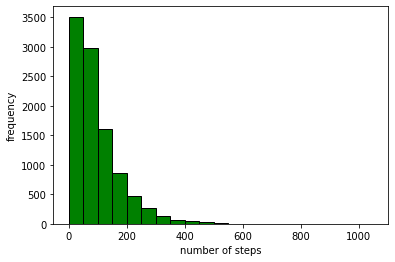

In [7]:
# find distribution of steps to find magic triangles
numTrials = 10000
stepList = [0]*numTrials
numSuccess = 0
for i in range(numTrials):
  res = findMagicTriangle(3, fastDist, 0.9, 10000, 1000000)
  if res[0] == 0:
    numSuccess += 1
    stepList[i] = res[2]
print("Finished! Num successes:", numSuccess)
print("min steps:", min(stepList), "; max steps:", max(stepList))

print(*stepList)
bins = np.linspace(0,1050,num=22)
n, b, p = plt.hist(stepList, bins=bins, color='g', edgecolor='k')
plt.xlabel("number of steps")
plt.ylabel("frequency")
print(n)

## 4-level experiments

Summary: Decrease factors near 0.9 seem to work best, with a median number of steps just above 200.

In [ ]:
# find avg. number of steps for various decFac values
decFacs = [0.85, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 0.99, 0.994, 0.997]
numTrials = 10000
df4 = pd.DataFrame(columns=["decFac","successes","avg steps","median steps","max steps"])

for d in decFacs:
  numSuccess = 0
  stepList = [0]*numTrials
  for i in range(numTrials):
    res = findMagicTriangle(4, fastDist, d, 10000, 1000000)
    if res[0] == 0:
      numSuccess += 1
      stepList[i] = res[2]
  row = pd.Series( {"decFac": d, "successes": numSuccess, "avg steps": stats.mean(stepList), "median steps": stats.median(stepList), "max steps": max(stepList)} , name=str(d))
  df4 = df4.append(row)
  print("decFac", d, ": success =", numSuccess, ", avg steps =", stats.mean(stepList), ", median steps =", stats.median(stepList))

In [9]:
df4

,decFac,successes,avg steps,median steps,max steps
0.85,0.850,10000.0,280.7463,211.0,2081.0
0.88,0.880,10000.0,280.5324,212.0,2296.0
0.9,0.900,10000.0,275.5891,204.0,2230.0
0.92,0.920,10000.0,276.8955,209.0,2283.0
0.94,0.940,10000.0,277.0719,210.0,2165.0
0.96,0.960,10000.0,282.0220,211.0,2712.0
0.98,0.980,10000.0,284.1465,216.0,2215.0
0.99,0.990,10000.0,300.8496,237.0,2220.0
0.994,0.994,10000.0,322.1691,258.0,2300.0
0.997,0.997,10000.0,365.7321,312.0,2126.0


In [11]:
# find distribution of steps to find magic triangles
numTrials = 10000
stepList = [0]*numTrials
numSuccess = 0
for i in range(numTrials):
  res = findMagicTriangle(4, fastDist, 0.9, 10000, 1000000)
  if res[0] == 0:
    numSuccess += 1
    stepList[i] = res[2]
print("Finished! Num successes:", numSuccess)
print("min steps:", min(stepList), "; max steps:", max(stepList))
#print(*stepList)

Finished! Num successes: 10000
min steps: 0 ; max steps: 2258


[2.239e+03 2.767e+03 1.791e+03 1.153e+03 7.980e+02 4.640e+02 2.780e+02
 1.800e+02 1.160e+02 6.700e+01 4.800e+01 3.400e+01 2.900e+01 9.000e+00
 9.000e+00 7.000e+00 3.000e+00 4.000e+00 1.000e+00 1.000e+00 0.000e+00
 2.000e+00]


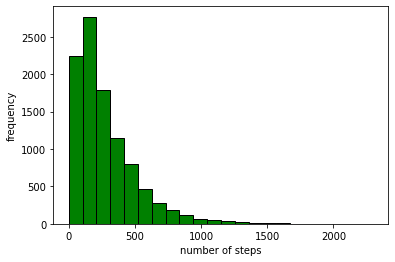

In [12]:
bins = np.linspace(0,2300,num=23)
n, b, p = plt.hist(stepList, bins=bins, color='g', edgecolor='k')
plt.xlabel("number of steps")
plt.ylabel("frequency")
print(n)

## 5-level experiments

Summary: decFac about 0.997 and reset about 10000 seem to work well, but there is substantial variability between trials

In [ ]:
# find avg. number of steps for various decFac and reset values
decFacs = [0.99, 0.994, 0.997, 0.998, 0.999, 0.9993, 0.9995]
resets = [10000, 20000, 30000, 40000]
numTrials = 1000

df5 = pd.DataFrame(columns=["decFac","reset","successes","avg steps","median steps","max steps"])

for d in decFacs:
  for r in resets:
    numSuccess = 0
    stepList = [0]*numTrials
    for i in range(numTrials):
      res = findMagicTriangle(5, fastDist, d, r, 1000000)
      if res[0] == 0:
        numSuccess += 1
        stepList[i] = res[2]
    row = pd.Series( {"decFac": d, "reset":r, "successes": numSuccess, "avg steps": stats.mean(stepList), "median steps": stats.median(stepList), "max steps": max(stepList)} , name=str(d))
    df5 = df5.append(row)
    print("decFac", d, "; reset", r, ": success =", numSuccess, ", avg steps =", stats.mean(stepList), ", median steps =", stats.median(stepList))

In [16]:
df5

,decFac,reset,successes,avg steps,median steps,max steps
0.99,0.9900,10000.0,1000.0,7734.962,3093.5,173645.0
0.99,0.9900,20000.0,1000.0,14480.479,3130.0,380555.0
0.99,0.9900,30000.0,1000.0,15499.127,3286.0,570663.0
0.99,0.9900,40000.0,1000.0,24749.995,3166.0,732928.0
0.994,0.9940,10000.0,1000.0,7000.854,3014.0,111779.0
0.994,0.9940,20000.0,1000.0,8187.335,3090.5,164793.0
0.994,0.9940,30000.0,1000.0,12710.593,3199.5,514050.0
0.994,0.9940,40000.0,1000.0,15333.560,3255.5,485486.0
0.997,0.9970,10000.0,1000.0,5940.203,3199.0,85931.0
0.997,0.9970,20000.0,1000.0,8000.534,3240.5,110286.0


In [24]:
# find distribution of steps to find magic triangles
numTrials = 10000
stepList = [0]*numTrials
numSuccess = 0
for i in range(numTrials):
  res = findMagicTriangle(5, fastDist, 0.997, 10000, 1000000)
  if res[0] == 0:
    numSuccess += 1
    stepList[i] = res[2]
print("Finished! Num successes:", numSuccess)
print("min steps:", min(stepList), "; max steps:", max(stepList))
#print(*stepList)

Finished! Num successes: 10000
min steps: 112 ; max steps: 92135


Text(0, 0.5, 'frequency')

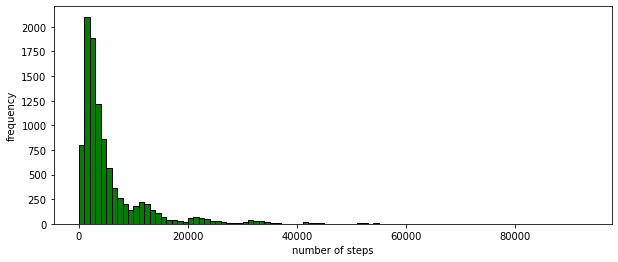

In [28]:
bins = np.linspace(0,93000,num=94)
plt.figure(figsize=(10,4))
n, b, p = plt.hist(stepList, bins=bins, color='g', edgecolor='k')
plt.xlabel("number of steps")
plt.ylabel("frequency")

## 6-level experiments

Summary: decFac about 0.994 and reset about 30000 seem to work well, but there is substantial variability between trials

In [ ]:
# find avg. number of steps for various decFac and reset values
decFacs = [0.99, 0.994, 0.997, 0.998, 0.999, 0.9993, 0.9995]
resets = [10000, 20000, 30000, 40000]
numTrials = 1000

df6 = pd.DataFrame(columns=["decFac","reset","successes","avg steps","median steps","max steps"])

for d in decFacs:
  for r in resets:
    numSuccess = 0
    stepList = [0]*numTrials
    for i in range(numTrials):
      res = findMagicTriangle(6, fastDist, d, r, 3000000)
      if res[0] == 0:
        numSuccess += 1
        stepList[i] = res[2]
    row = pd.Series( {"decFac": d, "reset":r, "successes": numSuccess, "avg steps": stats.mean(stepList), "median steps": stats.median(stepList), "max steps": max(stepList)} , name=str(d))
    df6 = df6.append(row)
    print("decFac", d, "; reset", r, ": success =", numSuccess, ", avg steps =", stats.mean(stepList), ", median steps =", stats.median(stepList))

In [18]:
df6

,decFac,reset,successes,avg steps,median steps,max steps
0.99,0.9900,10000.0,1000.0,7406.491,5531.5,35232.0
0.99,0.9900,20000.0,1000.0,7372.495,5268.0,44997.0
0.99,0.9900,30000.0,1000.0,7634.619,5369.5,45152.0
0.99,0.9900,40000.0,1000.0,7815.398,5741.0,50451.0
0.994,0.9940,10000.0,1000.0,7699.709,5499.0,65878.0
0.994,0.9940,20000.0,1000.0,7159.246,5176.0,51442.0
0.994,0.9940,30000.0,1000.0,7745.897,5476.0,38630.0
0.994,0.9940,40000.0,1000.0,8012.534,5970.5,80165.0
0.997,0.9970,10000.0,1000.0,8090.298,6110.5,45086.0
0.997,0.9970,20000.0,1000.0,7590.085,5452.5,55317.0


In [30]:
# find distribution of steps to find magic triangles
numTrials = 10000
stepList = [0]*numTrials
numSuccess = 0
for i in range(numTrials):
  res = findMagicTriangle(6, fastDist, 0.994, 30000, 1000000)
  if res[0] == 0:
    numSuccess += 1
    stepList[i] = res[2]
print("Finished! Num successes:", numSuccess)
print("Average number of steps:", sum(stepList)/numTrials)
print("min steps:", min(stepList), "; max steps:", max(stepList))
#print(*stepList)

Finished! Num successes: 10000
Average number of steps: 7657.2929
min steps: 129 ; max steps: 91115


Text(0, 0.5, 'frequency')

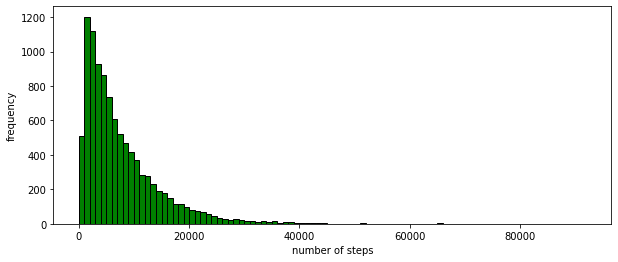

In [31]:
bins = np.linspace(0,92000,num=93)
plt.figure(figsize=(10,4))
n, b, p = plt.hist(stepList, bins=bins, color='g', edgecolor='k')
plt.xlabel("number of steps")
plt.ylabel("frequency")

## 7-level experiments

Summary: decFac about 0.998 and reset about 40000 seem to work well, but there is substantial variability between trials

In [19]:
# find avg. number of steps for various decFac and reset values
decFacs = [0.99, 0.994, 0.997, 0.998, 0.999]
resets = [30000, 40000, 50000]
numTrials = 1000

df7 = pd.DataFrame(columns=["decFac","reset","successes","avg steps","median steps","max steps"])

for d in decFacs:
  for r in resets:
    numSuccess = 0
    stepList = [0]*numTrials
    for i in range(numTrials):
      res = findMagicTriangle(7, fastDist, d, r, 3000000)
      if res[0] == 0:
        numSuccess += 1
        stepList[i] = res[2]
    row = pd.Series( {"decFac": d, "reset":r, "successes": numSuccess, "avg steps": stats.mean(stepList), "median steps": stats.median(stepList), "max steps": max(stepList)} , name=str(d))
    df7 = df7.append(row)
    print("decFac", d, "; reset", r, ": success =", numSuccess, ", avg steps =", stats.mean(stepList), ", median steps =", stats.median(stepList))


decFac 0.99 ; reset 30000 : success = 1000 , avg steps = 43526.859 , median steps = 33091.0
decFac 0.99 ; reset 40000 : success = 1000 , avg steps = 44934.474 , median steps = 36573.0
decFac 0.99 ; reset 50000 : success = 1000 , avg steps = 43168.291 , median steps = 33080.5
decFac 0.994 ; reset 30000 : success = 1000 , avg steps = 43762.867 , median steps = 35286.5
decFac 0.994 ; reset 40000 : success = 1000 , avg steps = 45272.18 , median steps = 34142.0
decFac 0.994 ; reset 50000 : success = 1000 , avg steps = 41350.807 , median steps = 33897.0
decFac 0.997 ; reset 30000 : success = 1000 , avg steps = 45265.182 , median steps = 33851.5
decFac 0.997 ; reset 40000 : success = 1000 , avg steps = 45178.267 , median steps = 34573.5
decFac 0.997 ; reset 50000 : success = 1000 , avg steps = 45618.53 , median steps = 34971.5
decFac 0.998 ; reset 30000 : success = 1000 , avg steps = 47859.59 , median steps = 36140.0
decFac 0.998 ; reset 40000 : success = 1000 , avg steps = 46907.947 , median

In [20]:
df7

,decFac,reset,successes,avg steps,median steps,max steps
0.99,0.990,30000.0,1000.0,43526.859,33091.0,216284.0
0.99,0.990,40000.0,1000.0,44934.474,36573.0,287769.0
0.99,0.990,50000.0,1000.0,43168.291,33080.5,280600.0
0.994,0.994,30000.0,1000.0,43762.867,35286.5,255970.0
0.994,0.994,40000.0,1000.0,45272.180,34142.0,273565.0
0.994,0.994,50000.0,1000.0,41350.807,33897.0,223772.0
0.997,0.997,30000.0,1000.0,45265.182,33851.5,292157.0
0.997,0.997,40000.0,1000.0,45178.267,34573.5,319058.0
0.997,0.997,50000.0,1000.0,45618.530,34971.5,222970.0
0.998,0.998,30000.0,1000.0,47859.590,36140.0,300454.0


In [33]:
# find distribution of steps to find magic triangles
numTrials = 2000
stepList = [0]*numTrials
numSuccess = 0
for i in range(numTrials):
  res = findMagicTriangle(7, fastDist, 0.998, 40000, 1000000)
  if res[0] == 0:
    numSuccess += 1
    stepList[i] = res[2]
  if i % 500 == 499:
    print("finished", (i+1))
print("Finished! Num successes:", numSuccess)
print("Average number of steps:", sum(stepList)/numTrials)
print("min steps:", min(stepList), "; max steps:", max(stepList))
#print(*stepList)

finished 500
finished 1000
finished 1500
finished 2000
Finished! Num successes: 2000
Average number of steps: 45869.6345
min steps: 1681 ; max steps: 332530


Text(0, 0.5, 'frequency')

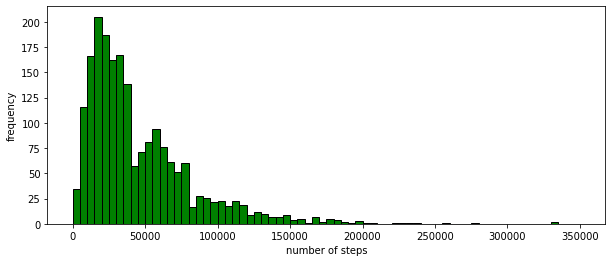

In [37]:
bins = np.linspace(0,350000,num=71)
plt.figure(figsize=(10,4))
n, b, p = plt.hist(stepList, bins=bins, color='g', edgecolor='k')
plt.xlabel("number of steps")
plt.ylabel("frequency")

## 8-level experiments

Summary: decFac about 0.999 and reset about 80000 seem to work well. However, experiments take a rather long time and there is substantial variablility between experiments (especially using only 100 trials, as below).

In [40]:
# find avg. number of steps for various decFac and reset values
decFacs = [0.997, 0.998, 0.999, 0.9993, 0.9995]
resets = [40000, 60000, 80000]
numTrials = 100

df8 = pd.DataFrame(columns=["decFac","reset","successes","avg steps","median steps","max steps"])

for d in decFacs:
  for r in resets:
    numSuccess = 0
    stepList = [0]*numTrials
    for i in range(numTrials):
      res = findMagicTriangle(8, fastDist, d, r, 3000000)
      if res[0] == 0:
        numSuccess += 1
        stepList[i] = res[2]
    row = pd.Series( {"decFac": d, "reset":r, "successes": numSuccess, "avg steps": stats.mean(stepList), "median steps": stats.median(stepList), "max steps": max(stepList)} , name=str(d))
    df8 = df8.append(row)
    print("decFac", d, "; reset", r, ": success =", numSuccess, ", avg steps =", stats.mean(stepList), ", median steps =", stats.median(stepList))

decFac 0.997 ; reset 40000 : success = 100 , avg steps = 224934.74 , median steps = 157583.5
decFac 0.997 ; reset 60000 : success = 100 , avg steps = 247551.45 , median steps = 177478.5
decFac 0.997 ; reset 80000 : success = 100 , avg steps = 249200.9 , median steps = 184840.5
decFac 0.998 ; reset 40000 : success = 100 , avg steps = 237916.1 , median steps = 179049.5
decFac 0.998 ; reset 60000 : success = 100 , avg steps = 250105.43 , median steps = 139585.5
decFac 0.998 ; reset 80000 : success = 100 , avg steps = 208600.51 , median steps = 159322.0
decFac 0.999 ; reset 40000 : success = 100 , avg steps = 240206.08 , median steps = 169394.0
decFac 0.999 ; reset 60000 : success = 100 , avg steps = 277901.35 , median steps = 202525.5
decFac 0.999 ; reset 80000 : success = 100 , avg steps = 228806.87 , median steps = 156683.0
decFac 0.9993 ; reset 40000 : success = 100 , avg steps = 237427.08 , median steps = 169146.5
decFac 0.9993 ; reset 60000 : success = 100 , avg steps = 254595.63 , m

In [41]:
df8

,decFac,reset,successes,avg steps,median steps,max steps
0.997,0.9970,40000.0,100.0,224934.74,157583.5,964712.0
0.997,0.9970,60000.0,100.0,247551.45,177478.5,1466065.0
0.997,0.9970,80000.0,100.0,249200.90,184840.5,1070802.0
0.998,0.9980,40000.0,100.0,237916.10,179049.5,1373101.0
0.998,0.9980,60000.0,100.0,250105.43,139585.5,1353216.0
0.998,0.9980,80000.0,100.0,208600.51,159322.0,1103988.0
0.999,0.9990,40000.0,100.0,240206.08,169394.0,881405.0
0.999,0.9990,60000.0,100.0,277901.35,202525.5,1079233.0
0.999,0.9990,80000.0,100.0,228806.87,156683.0,1057838.0
0.9993,0.9993,40000.0,100.0,237427.08,169146.5,2497769.0


In [43]:
# find distribution of steps to find magic triangles
numTrials = 500
stepList = [0]*numTrials
numSuccess = 0
for i in range(numTrials):
  res = findMagicTriangle(8, fastDist, 0.999, 80000, 5000000)
  if res[0] == 0:
    numSuccess += 1
    stepList[i] = res[2]
  if i % 100 == 99:
    print("  finished ", (i+1))
print("Finished! Num successes:", numSuccess)
print("Average number of steps:", stats.mean(stepList))
print("Median number of steps:", stats.median(stepList))
print("min steps:", min(stepList), "; max steps:", max(stepList))

  finished  100
  finished  200
  finished  300
  finished  400
  finished  500
Finished! Num successes: 500
Average number of steps: 233861.248
Median number of steps: 161262.0
min steps: 3665 ; max steps: 1628285


Text(0, 0.5, 'frequency')

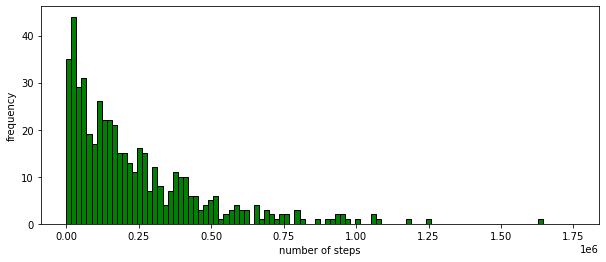

In [45]:
bins = np.linspace(0,1750000,num=101)
plt.figure(figsize=(10,4))
n, b, p = plt.hist(stepList, bins=bins, color='g', edgecolor='k')
plt.xlabel("number of steps")
plt.ylabel("frequency")

# Finding magic triangles with more than 8 levels

Here is a 9-level magic triangle:

(0, [54, 40, 6, 20, 13, 27, 42, 65, 14, 30, 64, 79, 71, 81, 52, 55, 9, 57, 44, 33, 61, 11, 50, 36, 35, 62, 68, 3, 48, 58, 47, 25, 17, 31, 32, 24, 37, 19, 21, 60, 74, 22, 4, 49, 34, 70, 72, 43, 66, 7, 10, 23, 8, 1, 69, 80, 28, 59, 38, 15, 67, 51, 77, 5, 29, 63, 12, 53, 45, 75, 2, 39, 76, 46, 41, 73, 78, 26, 18, 56, 16], 91704, 1.3366440543937382e-32)


[[738, 738, 738, 738, 738],
 [738, 738, 738, 738, 738],
 [738, 738, 738, 738, 738]]

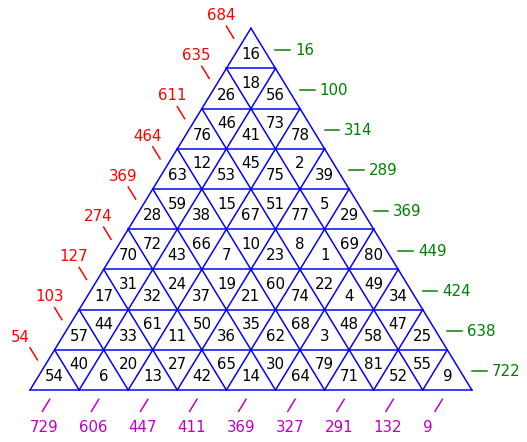

In [46]:
res = findMagicTriangle(9, findDistFromMagic, .9992, 100000, 5000000)
print(res)
drawTriangle(res[1])

Here is a 10-level magic triangle:

(0, [19, 43, 94, 7, 26, 89, 74, 21, 15, 47, 93, 97, 83, 54, 27, 25, 91, 4, 13, 14, 53, 80, 60, 42, 39, 17, 65, 10, 33, 23, 92, 75, 72, 41, 95, 55, 66, 45, 57, 63, 28, 96, 16, 78, 22, 5, 44, 67, 38, 98, 77, 64, 81, 71, 73, 59, 6, 2, 29, 30, 69, 32, 79, 20, 51, 9, 100, 50, 86, 49, 90, 35, 82, 84, 24, 56, 11, 1, 3, 52, 58, 76, 31, 62, 87, 99, 68, 8, 12, 85, 36, 61, 46, 37, 48, 18, 70, 34, 40, 88], 875281, 4.1562783019201315e-14)


[[1010, 1010, 1010, 1010, 1010],
 [1010, 1010, 1010, 1010, 1010],
 [1010, 1010, 1010, 1010, 1010]]

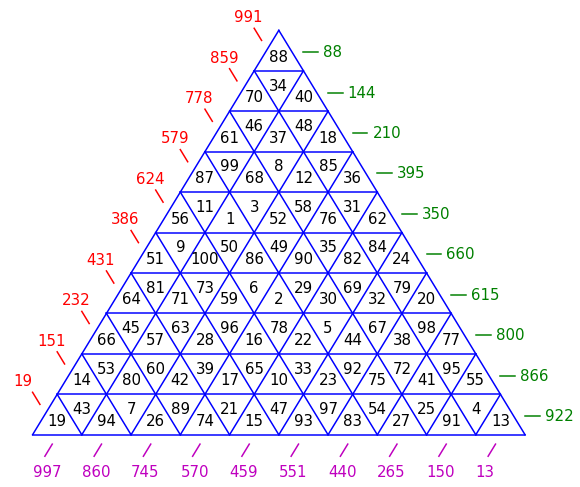

In [48]:
res = findMagicTriangle(10, findDistFromMagic, .9996, 160000, 5000000)
print(res)
drawTriangle(res[1])